### Airbnb Price Predictor: Step-by-Step Regression Analysis
Overview

Build a machine learning model to predict Airbnb nightly rates and discover underpriced gems using InsideAirbnb.com data.

## Step 1: Data Collection and Setup

### 1.1 Get the Data

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

#now models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Download data from InsideAirbnb.com
url='../data/listings.csv'
df = pd.read_csv(url)

### 1.2 Initial Data Exploration

In [2]:
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nMissing Values:\n {df.isnull().sum().sort_values(ascending=False).head(10)}")
print(f"\nPrice Statistics:\n {df['price'].describe()}")

Dataset shape: (36322, 79)
Columns: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availabilit

## Step 2: Data Cleaning and Preprocessing

### 2.1 Clean Price Column

In [3]:
# Remove $ and commas, convert to numeric
df['price']=df['price'].str.replace('$','').str.replace(',','')
df['price']=pd.to_numeric(df['price'],errors='coerce')


# Remove outliers (prices below $10 or above 99th percentile)
price_lower=10
price_upper=df['price'].quantile(0.99)
df=df[(df['price']>=price_lower) & df['price']<=price_upper]

# Log transform price for better distribution
df['log_price']=np.log(df['price'])

### Why do we use log?

1. Handle Skewed Price Distributions

- Airbnb prices are usually right-skewed: most listings are cheap, but some are extremely expensive.

- This skew can negatively affect regression models (especially Linear Regression, which assumes normally distributed residuals).
Log transformation:

  - Compresses high values
  - Spreads out lower values
  - Makes distribution more symmetric

   This helps the model learn better and generalize better.

2. Stabilize Variance (Homoscedasticity)
- Linear regression assumes constant variance of errors.
- When price is raw (and spread out), the variance often increases with the value.
- Log-transformed prices make residuals more uniform.



### 2.2 Feature Engineering

In [4]:
# Extract key features
features_to_create = {
    # Location features
    'latitude': df['latitude'],
    'longitude': df['longitude'],

    # Property features
    'accommodates': df['accommodates'],
    'bedrooms': df['bedrooms'].fillna(0),
    'beds': df['beds'].fillna(0),
    'bathrooms_text': df['bathrooms_text'],
    
    #Host features
    'host_is_superhost': df['host_is_superhost'].map({'t': 1, 'f': 0}).fillna(0),
    'host_identity_verified': df['host_identity_verified'].map({'t': 1, 'f': 0}).fillna(0),
    'host_response_rate': df['host_response_rate'].str.rstrip('%').astype('float') / 100,
    
    # Reviews features
    'number_of_reviews': df['number_of_reviews'],
    'review_scores_rating': df['review_scores_rating'].fillna(df['review_scores_rating'].median()),
    'reviews_per_month': df['reviews_per_month'].fillna(0),
    
    # Availability
    'availability_365': df['availability_365'],
    'minimum_nights': df['minimum_nights'],
    'maximum_nights': df['maximum_nights'],
    
    # Property type and room type
    'property_type': df['property_type'],
    'room_type': df['room_type'],
    'neighbourhood_cleansed': df['neighbourhood_cleansed']
}

# Create clean dataframe
clean_df = pd.DataFrame(features_to_create)
clean_df['price'] = df['price']
clean_df['log_price'] = df['log_price']

### 2.3 Handle Categorical Variables


In [5]:
# Encode categorical variables
categorical_features = ['property_type', 'room_type', 'neighbourhood_cleansed']
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    clean_df[f'{feature}_encoded'] = le.fit_transform(clean_df[feature].astype(str))
    label_encoders[feature] = le

property_dummies = pd.get_dummies(clean_df['property_type'], prefix='property')
room_dummies = pd.get_dummies(clean_df['room_type'], prefix='room')


# Combine all features
feature_df = pd.concat([
    clean_df.select_dtypes(include=[np.number]),
    property_dummies,
    room_dummies
], axis=1)

# Remove original categorical columns and price columns except target
feature_df = feature_df.drop(['price'], axis=1)

## Step 3: Feature Selection and Engineering

### 3.1 Correlation Analysis

Top 15 features correlated with log_price:
log_price                         1.000000
accommodates                      0.467964
room_Hotel room                   0.436043
room_Entire home/apt              0.396916
property_Room in hotel            0.362973
beds                              0.329090
property_Entire rental unit       0.282419
bedrooms                          0.188065
maximum_nights                    0.169796
neighbourhood_cleansed_encoded    0.150135
property_Entire condo             0.091382
property_Entire loft              0.082490
property_Entire townhouse         0.081551
latitude                          0.073603
host_identity_verified            0.071677
Name: log_price, dtype: float64


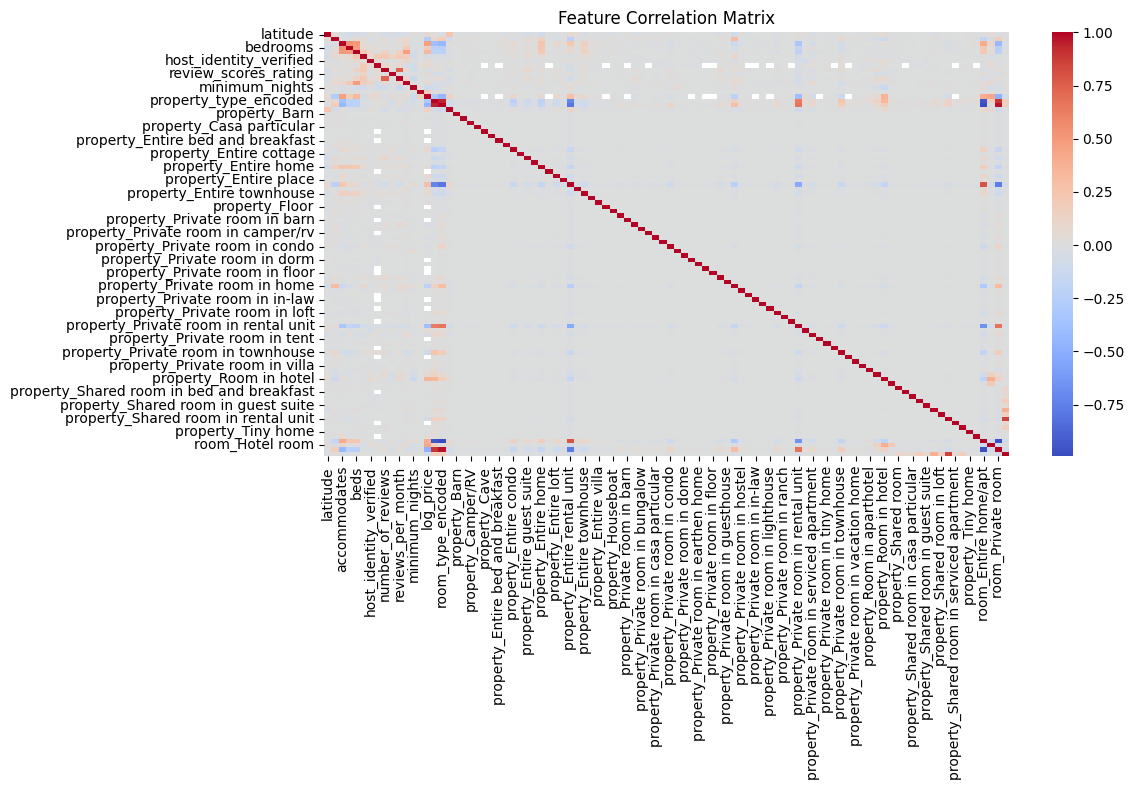

In [6]:
# Calculate correlations with log_price
correlations = feature_df.corr()['log_price'].sort_values(ascending=False)
print("Top 15 features correlated with log_price:")
print(correlations.head(15))

# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(feature_df.corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### 3.2 Create Additional Features

In [7]:
# Distance from city center (you'll need to define city center coordinates)
city_center_lat, city_center_lon = 40.7589, -73.9851  # NYC example

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points on Earth"""
    R = 6371  # Earth's radius in km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

feature_df['distance_to_center'] = haversine_distance(
    feature_df['latitude'], 
    feature_df['longitude'],
    city_center_lat, 
    city_center_lon
)

# Reviews per year since first review
feature_df['reviews_density'] = feature_df['reviews_per_month'] * 12

# Price per person
feature_df['beds_per_person'] = feature_df['beds'] / feature_df['accommodates']
feature_df['beds_per_person'] = feature_df['beds_per_person'].fillna(0)

## Step 4: Model Building and Training

### 4.1 Prepare Data for Modeling

In [8]:
# Remove rows with missing target values
model_df = feature_df.dropna(subset=['log_price'])

# Separate features and target
X = model_df.drop(['log_price'], axis=1)
y = model_df['log_price']

# Handle any remaining missing values
X = X.fillna(X.median())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4.2 Train Multiple Regression Models

In [9]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

model_results = {}

for name, model in models.items():
    if name == 'Random Forest':
        # Random Forest doesn't need scaling
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        # Linear models benefit from scaling
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    model_results[name] = {
        'model': model,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred
    }
    
    print(f"{name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")  
    print(f"  R²: {r2:.4f}")
    print()

Linear Regression:
  RMSE: 0.5748
  MAE: 0.4211
  R²: 0.6164

Ridge Regression:
  RMSE: 0.5748
  MAE: 0.4212
  R²: 0.6164

Lasso Regression:
  RMSE: 0.6360
  MAE: 0.4718
  R²: 0.5304

Random Forest:
  RMSE: 0.4074
  MAE: 0.2616
  R²: 0.8073



## Step 5: Model Evaluation and Interpretation

### 5.1 Compare Model Performance


Model Comparison:
               Model    RMSE     MAE      R²
0  Linear Regression  0.5748  0.4211  0.6164
1   Ridge Regression  0.5748  0.4212  0.6164
2   Lasso Regression  0.6360  0.4718  0.5304
3      Random Forest  0.4074  0.2616  0.8073


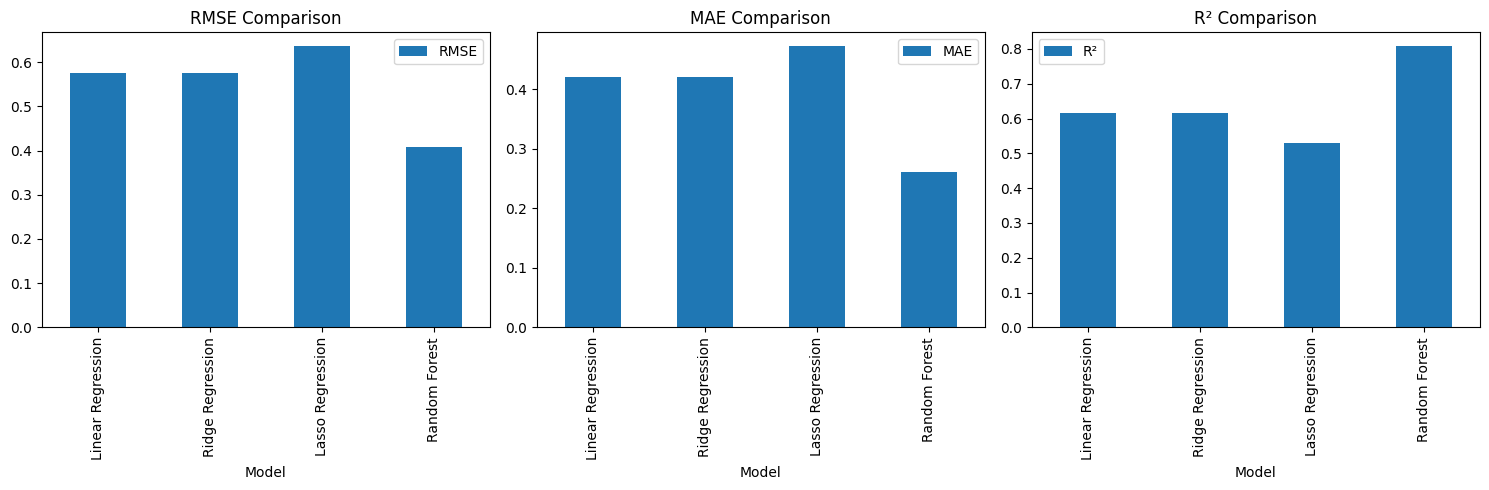

In [10]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'RMSE': [results['rmse'] for results in model_results.values()],
    'MAE': [results['mae'] for results in model_results.values()],
    'R²': [results['r2'] for results in model_results.values()]
})

print("Model Comparison:")
print(comparison_df.round(4))

# Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

comparison_df.plot(x='Model', y='RMSE', kind='bar', ax=axes[0], title='RMSE Comparison')
comparison_df.plot(x='Model', y='MAE', kind='bar', ax=axes[1], title='MAE Comparison')
comparison_df.plot(x='Model', y='R²', kind='bar', ax=axes[2], title='R² Comparison')

plt.tight_layout()
plt.show()

### 5.2 Feature Importance (for Random Forest)


Top 20 most important features:
                           feature  importance
15               room_type_encoded    0.236096
77          property_Room in hotel    0.175336
95              distance_to_center    0.085892
12                  minimum_nights    0.083210
2                     accommodates    0.071162
1                        longitude    0.052100
11                availability_365    0.049418
14           property_type_encoded    0.031731
3                         bedrooms    0.029686
0                         latitude    0.024912
7               host_response_rate    0.021097
13                  maximum_nights    0.018299
10               reviews_per_month    0.017833
96                 reviews_density    0.017637
9             review_scores_rating    0.016304
16  neighbourhood_cleansed_encoded    0.012843
8                number_of_reviews    0.012055
4                             beds    0.010435
97                 beds_per_person    0.006727
92                 room_Hote

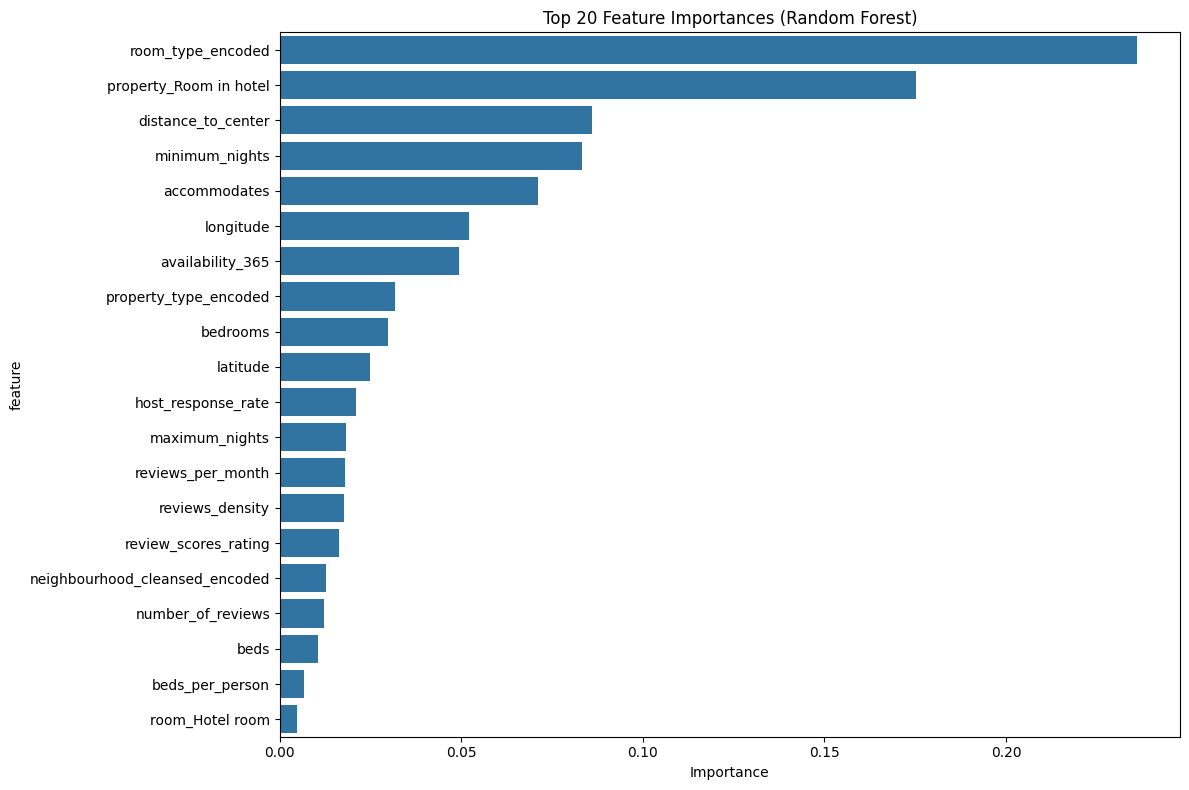

In [11]:
# Get feature importance from Random Forest
rf_model = model_results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 most important features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Step 6: Finding Underpriced Gems

### 6.1 Identify Underpriced Properties

In [12]:
# Use the best performing model
best_model_name = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']
best_model = model_results[best_model_name]['model']

print(f"Using {best_model_name} for predictions...")

# Make predictions on the full dataset
if best_model_name == 'Random Forest':
    y_pred_full = best_model.predict(X)
else:
    X_scaled_full = scaler.transform(X)
    y_pred_full = best_model.predict(X_scaled_full)

# Convert log predictions back to actual prices
predicted_prices = np.exp(y_pred_full)
actual_prices = np.exp(y)

# Calculate prediction errors
model_df['predicted_price'] = predicted_prices
model_df['actual_price'] = actual_prices
model_df['price_difference'] = model_df['actual_price'] - model_df['predicted_price']
model_df['price_ratio'] = model_df['actual_price'] / model_df['predicted_price']

# Find underpriced gems (actual price significantly lower than predicted)
underpriced_threshold = 0.8  # Actual price is 80% or less of predicted price
underpriced_gems = model_df[
    (model_df['price_ratio'] <= underpriced_threshold) &
    (model_df['actual_price'] >= 50)  # Minimum price filter
].sort_values('price_ratio')

print(f"Found {len(underpriced_gems)} potentially underpriced properties!")
print("\nTop 10 underpriced gems:")
print(underpriced_gems[['actual_price', 'predicted_price', 'price_ratio']].head(10))

Using Random Forest for predictions...
Found 1372 potentially underpriced properties!

Top 10 underpriced gems:
       actual_price  predicted_price  price_ratio
30187         503.0     40089.357081     0.012547
31384         533.0     27331.512573     0.019501
35277        1017.0     40080.157096     0.025374
12285         178.0      1010.622390     0.176129
24112         376.0      1970.837052     0.190782
26475         403.0      1918.149332     0.210098
15575         250.0      1039.761478     0.240440
18040          95.0       393.313137     0.241538
24025         286.0      1057.473976     0.270456
35196        1308.0      4753.528262     0.275164


### 6.2 Analyze Underpriced Properties

In [13]:
# Add original data for analysis
underpriced_analysis = underpriced_gems.copy()

# Map back to original data to get property details
original_indices = underpriced_gems.index
underpriced_details = df.loc[original_indices, [
    'name', 'neighbourhood_cleansed', 'property_type', 'room_type',
    'accommodates', 'bedrooms', 'beds', 'price', 'review_scores_rating',
    'number_of_reviews', 'host_is_superhost'
]].copy()

underpriced_details['predicted_price'] = underpriced_gems['predicted_price'].values
underpriced_details['savings'] = underpriced_details['predicted_price'] - underpriced_details['price']
underpriced_details['savings_pct'] = (1 - underpriced_details['price']/underpriced_details['predicted_price']) * 100

print("Best deals with property details:")
print(underpriced_details[['name', 'neighbourhood_cleansed', 'property_type', 
                          'price', 'predicted_price', 'savings', 'savings_pct']].head(10))

Best deals with property details:
                                                    name  \
30187       Stylish Unit at Wythe Hotel w/ Amazing Views   
31384  Double Park View, Public - Sophisticated New York   
35277    2 Units, Public Hotel New York, Queen with View   
12285            Spacious Studio Loft, East Williamsburg   
24112       Just What You Were Looking For! Pets Allowed   
26475               Premier Studio Room at Ink 48 Hotel!   
15575      Fully Furnish PH 2 bed 2 bath Duplex 1500 SQF   
18040   Sunny studio by Hudson Yards, subways, High Line   
24025       Experience NYC! 4 Min Walk from Empire State   
35196   Elegant Penthouse Suite with Unmatched NYC Views   

      neighbourhood_cleansed       property_type   price  predicted_price  \
30187           Williamsburg       Room in hotel   503.0     40089.357081   
31384        Lower East Side       Room in hotel   533.0     27331.512573   
35277        Lower East Side       Room in hotel  1017.0     40080.157096 

## Step 7: Model Validation and Insights


### 7.1 Cross-Validation

In [14]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the best model
if best_model_name == 'Random Forest':
    cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
else:
    cv_scores = cross_val_score(best_model, X_scaled_full, y, cv=5, scoring='r2')

print(f"Cross-validation R² scores for {best_model_name}:")
print(f"Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation R² scores for Random Forest:
Mean: 0.7443 (+/- 0.1020)


## Step 8: Deployment and Usage

### 8.1 Create Prediction Function

In [16]:
def predict_airbnb_price(property_features, model=best_model, scaler=scaler):
    """
    Predict Airbnb price for a given property
    
    Args:
        property_features: dict with property characteristics
        model: trained model
        scaler: fitted scaler
    
    Returns:
        predicted_price: estimated nightly rate
    """
    # Convert features to DataFrame
    feature_df = pd.DataFrame([property_features])
    
    # Apply same preprocessing as training data
    if best_model_name == 'Random Forest':
        log_price_pred = model.predict(feature_df)[0]
    else:
        feature_scaled = scaler.transform(feature_df)
        log_price_pred = model.predict(feature_scaled)[0]
    
    return np.exp(log_price_pred)

# Example usage
example_property = {
    'accommodates': 4,
    'bedrooms': 2,
    'beds': 2,
    'latitude': 40.7505,
    'longitude': -73.9934,
    'room_type_encoded': 0,  # Entire home/apt
    'property_type_encoded': 1,  # Apartment
    # ... include all required features
}

# predicted_price = predict_airbnb_price(example_property)
# print(f"Predicted price: ${predicted_price:.2f}")

### 8.2 Save Model for Future Use

In [29]:
import joblib
import os

save_dir = '../models'
os.makedirs(save_dir, exist_ok=True)  # Create folder if it doesn't exist



# Define file paths
model_path = os.path.join(save_dir, f'airbnb_price_model_{best_model_name.lower().replace(" ", "_")}.pkl')
scaler_path = os.path.join(save_dir, 'airbnb_price_scaler.pkl')
encoders_path = os.path.join(save_dir, 'airbnb_label_encoders.pkl')

# Save the trained model and scaler
joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(label_encoders, encoders_path)

# print("Model saved successfully!")

['../models/airbnb_label_encoders.pkl']